In [1]:
import os
import pandas as pd
import numpy as np
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
from hostphot._constants import workdir
#workdir="/Users/clidman/Official/Students/Dingyuan/WorkedExampleAndNotes/images/"

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Fontconfig warning: ignoring UTF-8: not a valid region tag
/Users/dingyuancao/opt/anaconda3/envs/Hostphot/lib/python3.11/site-packages/hostphot/utils.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  config_df = pd.read_csv(config_file, delim_whitespace=True)
/Users/dingyuancao/opt/anaconda3/envs/Hostphot/lib/python3.11/site-packages/hostphot/sed_plotting.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  config_df = pd.read_csv(config_file, delim_whitespace=True)


In [47]:
FN_Host_properties = pd.read_csv('FN_Host_properties.csv')
FN_shapes = pd.read_csv('FN_shapes.csv')
FN_low_thresh = pd.read_csv('FN_shape_low_threshold.csv')
FN_low_thresh2 = pd.read_csv('FN_shape_low_threshold copy.csv')
DEBASS_low_thresh = pd.read_csv('DEBASS_shape_low_threshold.csv')
DEBASS_allHosts = pd.read_csv('DEBASS_allHost.csv')

In [5]:
# Create a crossmatched catalogue using topcat
FN=pd.read_csv('FN_combined.csv')

## Angular separation between SN and Host galaxy

In [48]:
SN_RA = DEBASS_allHosts['SN_RA'] 
SN_DEC = DEBASS_allHosts['SN_DEC']
HOST_RA = DEBASS_allHosts['HOST_RA']
HOST_DEC = DEBASS_allHosts['HOST_DEC']

In [36]:
SN_RA = np.array(FN_Host_properties['SN_RA'])[0] # Except SN2016coj
SN_DEC = np.array(FN_Host_properties['SN_DEC'])[0]
HOST_RA = 182.02431 #np.array(FN_Host_properties['HOST_RA'])[0] 	
HOST_DEC = 65.17431 #np.array(FN_Host_properties['HOST_DEC'])[0]

In [49]:
# 
#ANG_SEP = [] # arcsec
#for i in range(len(SN_RA)):
#    ang_sep_deg = np.sqrt(((SN_RA[i]-HOST_RA[i])*np.cos(SN_DEC[i]))**2 + (SN_DEC[i]-HOST_DEC[i])**2)
#    ang_sep_arcsec = (ang_sep_deg*(u.deg)).to(u.arcsec)
#    ANG_SEP.append(ang_sep_arcsec.value)

# You can use numoy arithmetic to do this more neatly

deg2rad=np.pi / 180.

delta_RA=(SN_RA-HOST_RA)*np.cos(SN_DEC * deg2rad)
delta_DEC=SN_DEC-HOST_DEC

# The separation of the SN from the host

ANG_SEP = (np.sqrt(delta_RA**2+delta_DEC**2))*(u.deg).to(u.arcsec)

# The position angle of the SN on the sky relative to the host !!

PA_SN=np.arctan2(delta_DEC,-delta_RA)-np.pi/2

#print(delta_RA[124]*(u.deg).to(u.arcsec),delta_DEC[124]*(u.deg).to(u.arcsec),PA_SN[124]*180/np.pi)



## Pixel scale

In [50]:
# Get the pixel scale using PS1 images from the riz coadd
# Use 2021dha as an example
# Assumes all images have the same pixel scale
obj_dir = os.path.join(workdir, '2021dha')
obj_PS1fits = os.path.join(obj_dir, f"{'PS1'}_{'riz'}.fits")

img_wcs_PS1=WCS(obj_PS1fits)
pixel_scale_PS1 = img_wcs_PS1.proj_plane_pixel_scales()[0].to(u.arcsec)

print("The pixel scale is %4.3f arcsec" % pixel_scale_PS1.value)


The pixel scale is 0.250 arcsec


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [51]:
# Convert the semi-major and semi-minor axes to arcsec
#semi_major = []
#semi_minor = []
#for i in range(len(FN_shapes)):
#    semi_major.append(FN_shapes['a'][i]*pixel_scale_PS1)
#    semi_minor.append(FN_shapes['b'][i]*pixel_scale_PS1)
    
semi_major=DEBASS_low_thresh['a']*pixel_scale_PS1
semi_minor=DEBASS_low_thresh['b']*pixel_scale_PS1

# semi_major=18.094768524169922*pixel_scale_PS1
# semi_minor=10.938899993896484*pixel_scale_PS1

In [52]:
# Assume all PS1 images have the same angle on sky - this needs to be tested
# The PA of the major axis    !!!
rot_offset= np.pi / 2.
PA=DEBASS_low_thresh['theta']+rot_offset 

# The angular offset between the SN and the host's major acis

delta_PA=PA_SN-PA


## DLR

In [53]:
#DLRs = [] # arcsec
#for i in range(len(semi_major)):
#    DLR = (semi_major[i]*semi_minor[i])/(np.sqrt((semi_major[i]*np.sin(PA[i]))**2 + (semi_minor[i]*np.cos(PA[i]))**2))
#    DLRs.append(DLR.value)
    
DLRs = (semi_major*semi_minor)/(np.sqrt((semi_major*np.sin(delta_PA))**2 + (semi_minor*np.cos(delta_PA))**2))

## dDLR

In [54]:
#dDLR = []
#for i in range(len(DLRs)):
#    dDLR.append(ANG_SEP[i]/DLRs[i])
    
dDLR=ANG_SEP/DLRs

In [44]:
print(dDLR)

3.875773153234129 1 / arcsec


In [55]:
# Keep all DLRs
#filtered_dDLR = [x for x in dDLR if x > 0 and x <= 4]
#np.median(filtered_dDLR), min(filtered_dDLR), max(filtered_dDLR)

print("The median dDLR is %4.2f" % np.median(dDLR))

The median dDLR is 1.29


In [59]:
DE_dDLR=pd.DataFrame({'Names':DEBASS_low_thresh['snid'],'dDLR':dDLR})
DE_dDLR.to_csv('DE_dDLR.csv',index=False)

In [27]:
FN_dDLR=pd.DataFrame({'Names':FN_low_thresh['Names'],'dDLR':dDLR})
FN_dDLR.to_csv('FN_dDLR.csv',index=False)

273


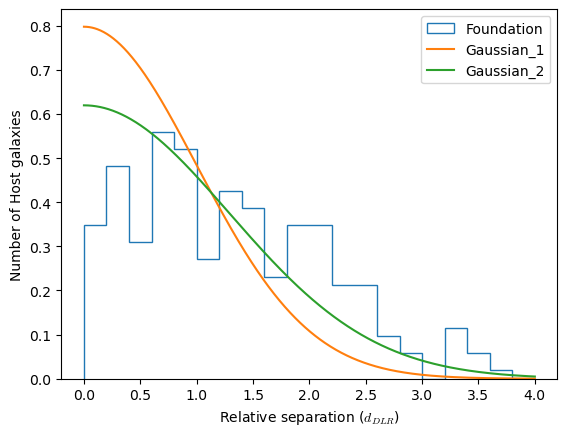

In [56]:
print(len(dDLR))
bins=np.arange(0,4,0.2)
plt.hist(dDLR, bins=bins, density=True,histtype='step', rwidth=0.85, label="Foundation")
plt.xlabel('Relative separation ($d_{DLR}$)')
plt.ylabel('Number of Host galaxies')

# Define Gaussian function
# This needs to be a one-sided Guassian
def gaussian(x, mean, sigma):
    return (2./(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sigma)**2)

# Generate x values for the Gaussian curve
x = np.linspace(0,4, 1000)

plt.plot(x, gaussian(x, 0, 1), label='Gaussian_1')
plt.plot(x, gaussian(x, 0, np.median(dDLR)), label='Gaussian_2')

plt.legend()

163


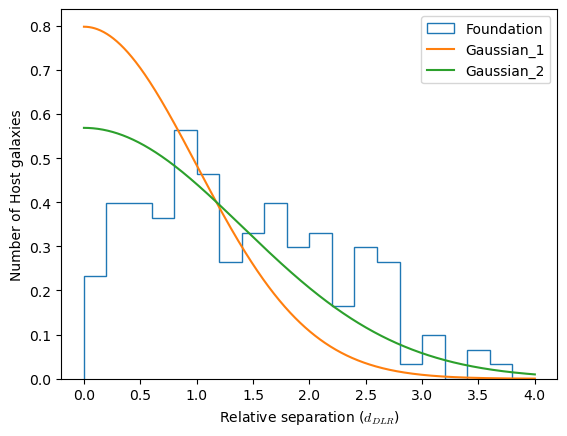

In [25]:
# Using low threshold
print(len(dDLR))
bins=np.arange(0,4,0.2)
plt.hist(dDLR, bins=bins, density=True,histtype='step', rwidth=0.85, label="Foundation")
plt.xlabel('Relative separation ($d_{DLR}$)')
plt.ylabel('Number of Host galaxies')

# Define Gaussian function
# This needs to be a one-sided Guassian
def gaussian(x, mean, sigma):
    return (2./(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sigma)**2)

# Generate x values for the Gaussian curve
x = np.linspace(0,4, 1000)

plt.plot(x, gaussian(x, 0, 1), label='Gaussian_1')
plt.plot(x, gaussian(x, 0, np.median(dDLR)), label='Gaussian_2')

plt.legend()

163


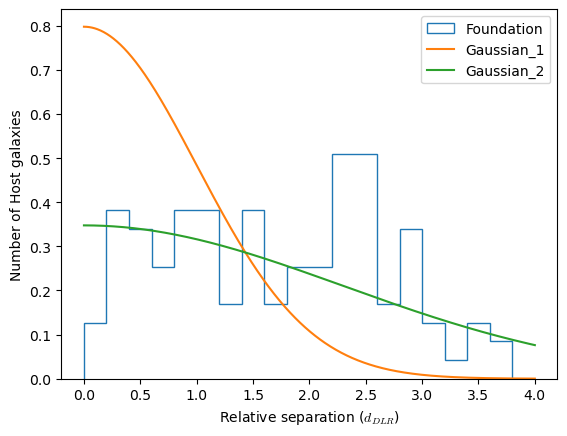

In [64]:
print(len(dDLR))
bins=np.arange(0,4,0.2)
plt.hist(dDLR, bins=bins, density=True,histtype='step', rwidth=0.85, label="Foundation")
plt.xlabel('Relative separation ($d_{DLR}$)')
plt.ylabel('Number of Host galaxies')

# Define Gaussian function
# This needs to be a one-sided Guassian
def gaussian(x, mean, sigma):
    return (2./(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sigma)**2)

# Generate x values for the Gaussian curve
x = np.linspace(0,4, 1000)

plt.plot(x, gaussian(x, 0, 1), label='Gaussian_1')
plt.plot(x, gaussian(x, 0, np.median(dDLR)), label='Gaussian_2')

plt.legend()

In [32]:
## Some checks

print(FN['Names'][37])
print(SN_RA[37],SN_DEC[37],HOST_RA[37],HOST_DEC[37])
print(ANG_SEP[37])
print(semi_major[37])
print(dDLR[37])
print(DLRs[37])


from astropy import units as u
from astropy.coordinates import SkyCoord, Distance

# Distance of the SN from the centre of the host

SN=SkyCoord(SN_RA[24]*u.deg, SN_DEC[24]*u.deg)
Host=SkyCoord(HOST_RA[24]*u.deg, HOST_DEC[24]*u.deg)
print("SN is %4.3f arcsec away" % SN.separation(Host).arcsec)



PS15cku
21.0939 3.5876 21.093329 3.588014
2.5357914559752426
3.2639525727021947
0.7844221874203415
3.2326870614336793
SN is 19.055 arcsec away
